In [17]:
%matplotlib notebook

In [18]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [19]:
line = xt.Line.from_json('pimms_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Set  the extraction sextupoles

In [20]:
line.vars['kse1'] = 1
line.vars['kse2'] = -6.5

### Visualize the phase space topology

In [21]:
# Generate 20 particles on the x axis
x_gen = np.linspace(0, 2.5e-2, 20)
particles = line.build_particles(x=x_gen, px=0, y=0, py=0, zeta=0, delta=0)

# Inspect the particles
particles.get_table()

Table: 20 rows, 17 cols
particle_id s          x px y py zeta delta chi charge_ratio weight pdg_id at_element at_turn ...
          0 0          0  0 0  0    0     0   1            1      1      0          0       0
          1 0 0.00131579  0 0  0    0     0   1            1      1      0          0       0
          2 0 0.00263158  0 0  0    0     0   1            1      1      0          0       0
          3 0 0.00394737  0 0  0    0     0   1            1      1      0          0       0
          4 0 0.00526316  0 0  0    0     0   1            1      1      0          0       0
          5 0 0.00657895  0 0  0    0     0   1            1      1      0          0       0
          6 0 0.00789474  0 0  0    0     0   1            1      1      0          0       0
          7 0 0.00921053  0 0  0    0     0   1            1      1      0          0       0
          8 0  0.0105263  0 0  0    0     0   1            1      1      0          0       0
          9 0  0.0118421  0 0  0

In [22]:
# Track 1000 turns logging turn-by-turn data
num_turns = 1000
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
rec = line.record_last_track

<IPython.core.display.Javascript object>


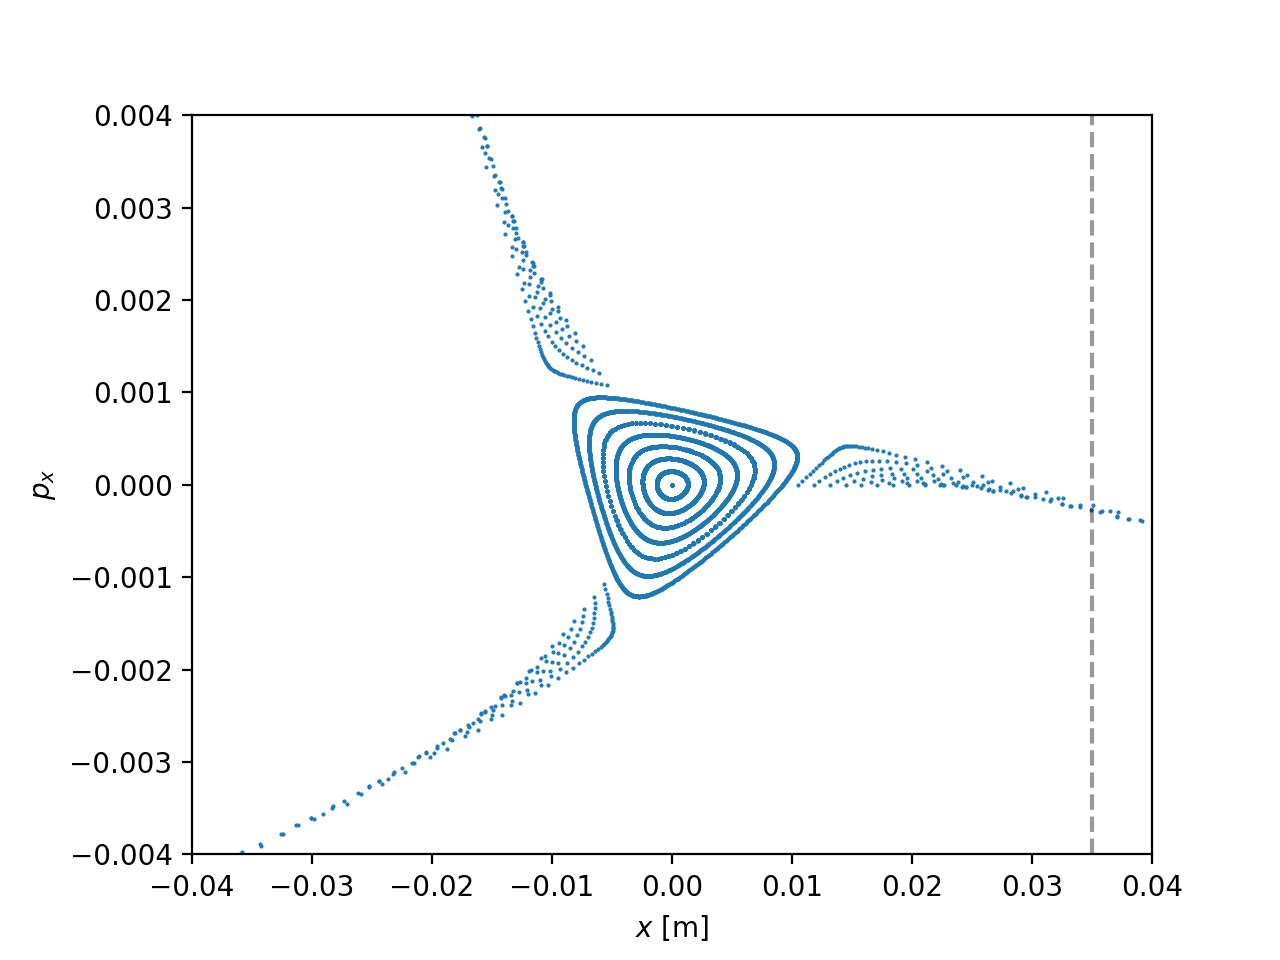

In [23]:
# Plot turn by turn data
plt.figure()
plt.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')
plt.xlim(-4e-2, 4e-2)
plt.ylim(-4e-3, 4e-3)
plt.subplots_adjust(left=.15)

# Mark septum position
x_septum = 3.5e-2
plt.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')

In [24]:
# Compute normalized coordinates
tw = line.twiss(method='4d')
nc  = tw.get_normalized_coordinates(rec)

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


<IPython.core.display.Javascript object>


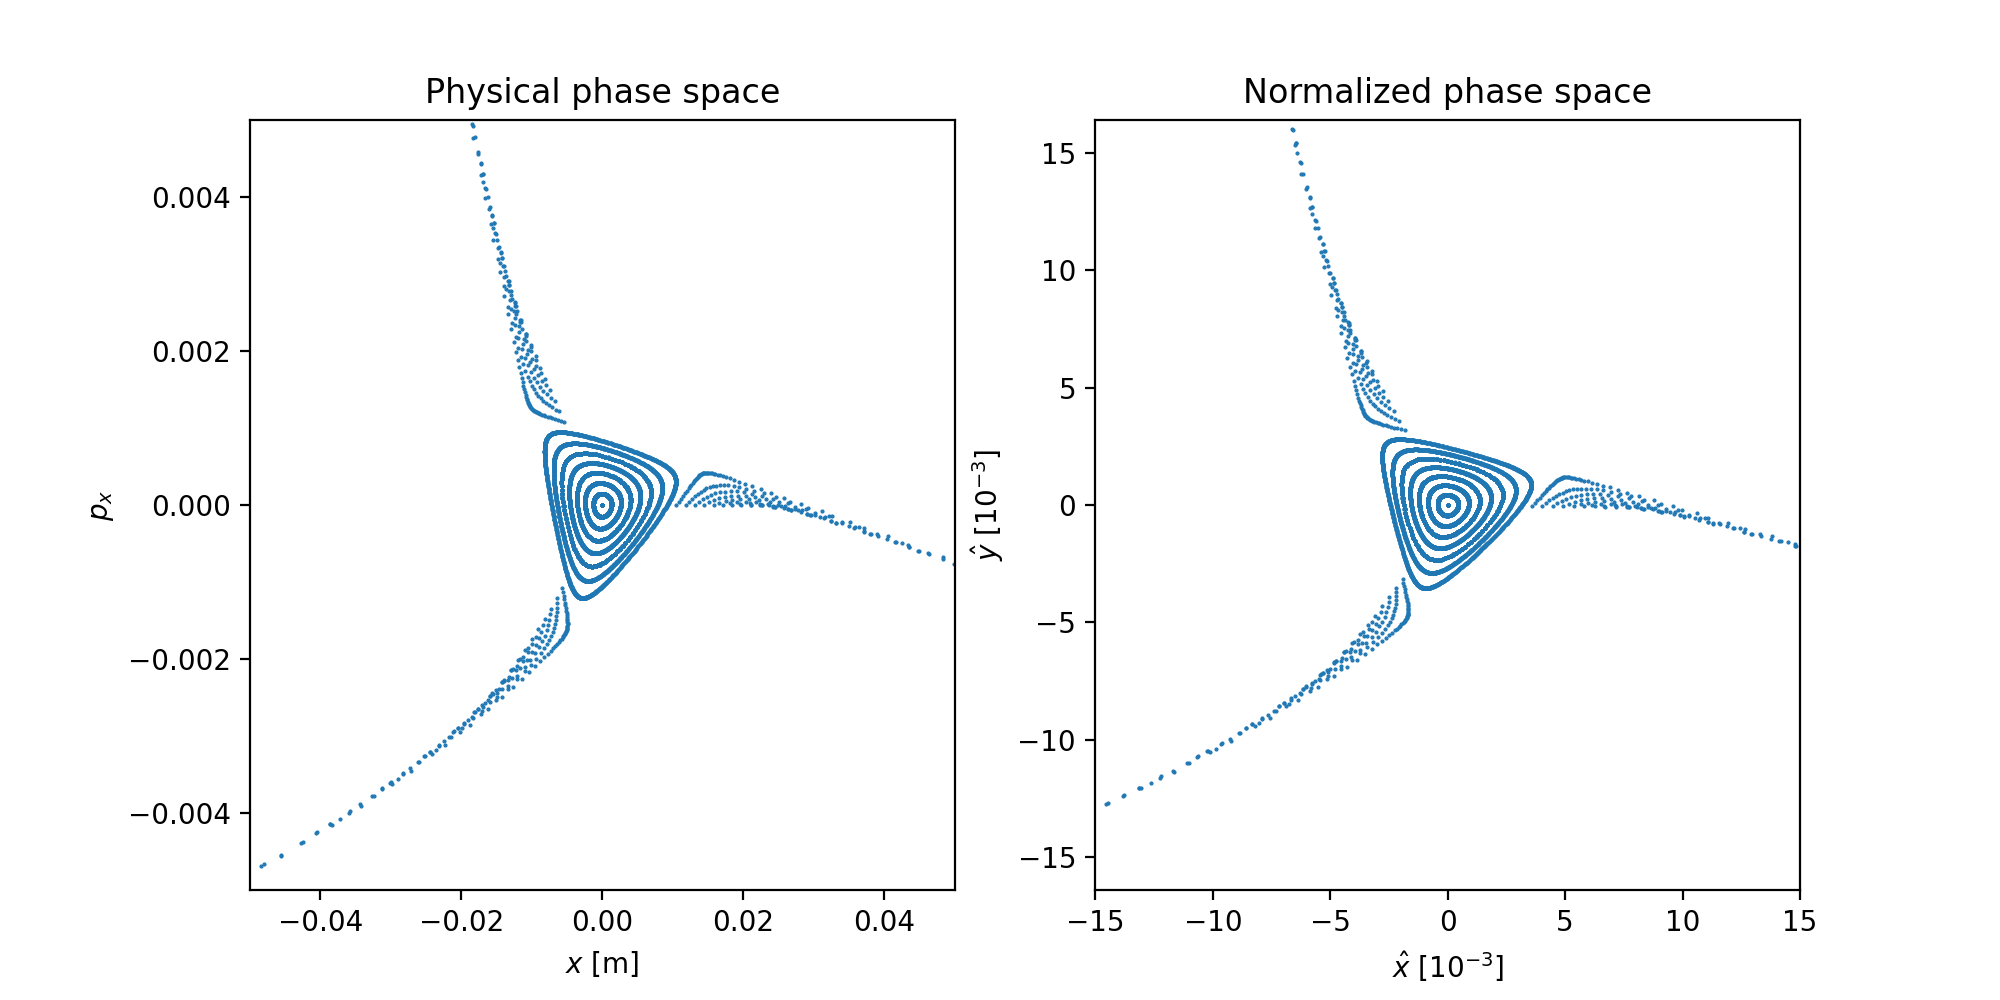

Text(0.5, 1.0, 'Normalized phase space')

In [25]:
# Plot side by side
plt.figure(figsize=(10, 5))

ax_geom = plt.subplot(1, 2, 1)
plt.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')
plt.xlim(-5e-2, 5e-2)
plt.ylim(-5e-3, 5e-3)

ax_norm = plt.subplot(1, 2, 2)
plt.plot(nc.x_norm.T * 1e3, nc.px_norm.T * 1e3,
         '.', markersize=1, color='C0')

plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel(r'$\hat{x}$ [$10^{-3}$]')
plt.ylabel(r'$\hat{y}$ [$10^{-3}$]')
ax_geom.set_title('Physical phase space')
ax_norm.set_title('Normalized phase space')


## Find separatrix

In [26]:
# We use some logic written in python to localize the transition
# between stable and unstable motion

# Sepratrix search region
search_region = [0, 0.03]

while search_region[1] - search_region[0] > 1e-6:
    
    # Generate a particle in the middle of the region
    x_test = (search_region[0] + search_region[1]) / 2
    p = line.build_particles(x=x_test, px=0)
    
    # Track
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    rec_test = line.record_last_track
    
    # Update the search region
    if (rec_test.x > x_septum).any():
        # Test particle is unstable
        # => Sepearatrix is on the right w.r.t x_test
        search_region[1] = x_test
    else:
        # Test particle is stable
        # Sepearatrix is on the left w.r.t x_test
        search_region[0] = x_test

In [28]:
# We track particles at the edges of narrowed-down search region
p = line.build_particles(x=search_region)
line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
rec_separ = line.record_last_track

# Get corresponding normalized coordinates
nc_separ = tw.get_normalized_coordinates(rec_separ)

<IPython.core.display.Javascript object>


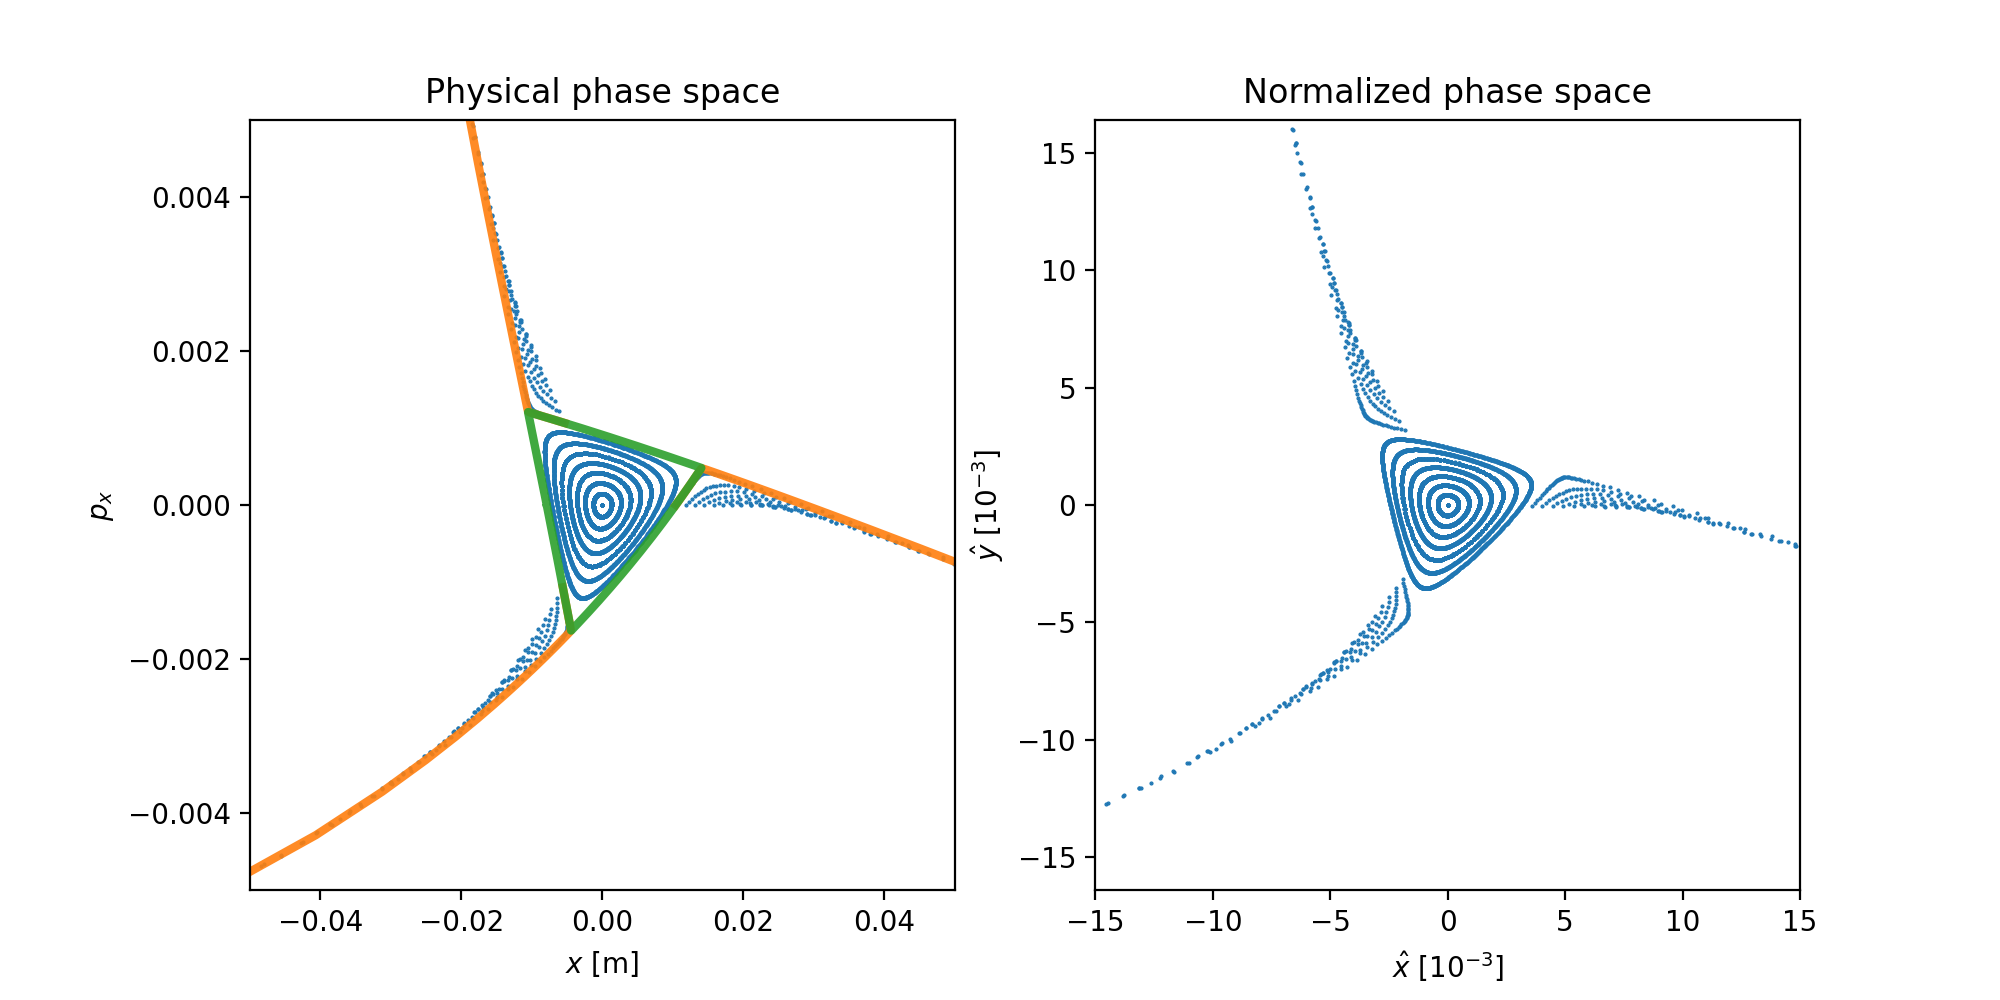

In [31]:
# Plot separatrix in physical and normalized phase space
plt.figure(figsize=(10, 5))

ax_geom = plt.subplot(1, 2, 1)
plt.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')
plt.xlim(-5e-2, 5e-2)
plt.ylim(-5e-3, 5e-3)

ax_norm = plt.subplot(1, 2, 2)
plt.plot(nc.x_norm.T * 1e3, nc.px_norm.T * 1e3,
         '.', markersize=1, color='C0')

plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel(r'$\hat{x}$ [$10^{-3}$]')
plt.ylabel(r'$\hat{y}$ [$10^{-3}$]')
ax_geom.set_title('Physical phase space')
ax_norm.set_title('Normalized phase space')


x_triang =rec_separ.x[0, :]
px_triang = rec_separ.px[0, :]
x_norm_triang = nc_separ.x_norm[0, :]
px_norm_triang = nc_separ.px_norm[0, :]
theta_triang = np.angle(x_norm_triang + 1j * px_norm_triang)
idx = np.argsort(theta_triang)
x_triang = x_triang[idx]
px_triang = px_triang[idx]
x_norm_triang = x_norm_triang[idx]
px_norm_triang = px_norm_triang[idx]

mask_alive = rec_separ.state[1, :] > 0
for ii in range(3):
    ax_geom.plot(rec_separ.x[1, mask_alive][ii::3],
                 rec_separ.px[1, mask_alive][ii::3],
                 '-', lw=3, color='C1', alpha=0.9)
ax_geom.plot(x_triang, px_triang, '-', lw=3, color='C2', alpha=0.9)


### Track identified particles

In [ ]:
p = line.build_particles(x=[x_stable, x_unstable], px=0)
line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
mon_separatrix = line.record_last_track
nc_sep = tw.get_normalized_coordinates(mon_separatrix)

In [ ]:
plt.figure(figsize=(10, 5))
ax_geom = plt.subplot(1, 2, 1)
plt.plot(mon.x.T, mon.px.T, '.', markersize=1, color='C0')
plt.ylabel(r'$p_x$')
plt.xlabel(r'$x$ [m]')
plt.xlim(-5e-2, 5e-2)
plt.ylim(-5e-3, 5e-3)
ax_norm = plt.subplot(1, 2, 2)
plt.plot(nc.x_norm.T * 1e3, nc.px_norm.T * 1e3,
         '.', markersize=1, color='C0')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.gca().set_aspect('equal', adjustable='datalim')

plt.xlabel(r'$\hat{x}$')
plt.ylabel(r'$\hat{y}$')

# Plot separatrix
ax_geom.plot(mon_separatrix.x[0, :], mon_separatrix.px[0, :], '.r')
ax_geom.plot(mon_separatrix.x[1, :], mon_separatrix.px[1, :], '.g')
ax_norm.plot(nc_sep.x_norm[0, :] * 1e3, nc_sep.px_norm[0, :] * 1e3, '.r')
ax_norm.plot(nc_sep.x_norm[1, :] * 1e3, nc_sep.px_norm[1, :] * 1e3, '.', c='C1')


In [ ]:
# Find fixed points
z_triang = nc_sep.x_norm[0, :] + 1j * nc_sep.px_norm[0, :]
r_triang = np.abs(z_triang)

i_fp1 = np.argmax(r_triang)
z_fp1 = z_triang[i_fp1]
r_fp1 = np.abs(z_fp1)

mask_fp2 = np.abs(z_triang - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
i_fp2 = np.argmax(r_triang * mask_fp2)

mask_fp3 = np.abs(z_triang - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
i_fp3 = np.argmax(r_triang * mask_fp3)


x_norm_fp = np.array([nc_sep.x_norm[0, i_fp1],
                      nc_sep.x_norm[0, i_fp2],
                      nc_sep.x_norm[0, i_fp3]])
px_norm_fp = np.array([nc_sep.px_norm[0, i_fp1],
                       nc_sep.px_norm[0, i_fp2],
                       nc_sep.px_norm[0, i_fp3]])

stable_area = np.linalg.det([x_norm_fp, px_norm_fp, [1,1,1]])

plt.plot(x_norm_fp*1e3, px_norm_fp*1e3, '*', markersize=10, color='k')

In [ ]:
# Measure slope of the separatrix at the semptum
x_separ = mon_separatrix.x[1, :]
px_separ = mon_separatrix.px[1, :]
x_norm_separ = nc_sep.x_norm[1, :]
px_norm_separ = nc_sep.px_norm[1, :]
i_septum = np.argmin(np.abs(x_separ - x_septum))

poly_sep = np.polyfit([x_separ[i_septum + 3], x_separ[i_septum - 3]],
                         [px_separ[i_septum + 3], px_separ[i_septum - 3]],
                          deg=1)
x_plt = [x_septum - 1e-2, x_septum + 1e-2]
ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k')
